# Predicting COVID-19 in Europe with Random Forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
from pandas.plotting import lag_plot
from matplotlib import pyplot as plt
from matplotlib.dates import date2num
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
import json
plt.close("all")

euroData = pd.read_csv("data/euro_countries_padded.csv")
with open("data/iso_country_codes.json", "r") as read_file:
    countryCodes = json.load(read_file)

euroData.head(5)


Bad key savefig.frameon in file /home/alpakkan/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/alpakkan/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/alpakkan/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an upd

,Unnamed: 0,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,population,total_tests,new_tests,new_tests_smoothed
0,0,ALB,Albania,2019-12-31,0.0,0.0,0.0,2877800.0,0.0,0.0,0.0
1,1,ALB,Albania,2020-01-01,0.0,0.0,0.0,2877800.0,0.0,0.0,0.0
2,2,ALB,Albania,2020-01-02,0.0,0.0,0.0,2877800.0,0.0,0.0,0.0
3,3,ALB,Albania,2020-01-03,0.0,0.0,0.0,2877800.0,0.0,0.0,0.0
4,4,ALB,Albania,2020-01-04,0.0,0.0,0.0,2877800.0,0.0,0.0,0.0


In [2]:
df = euroData.groupby("date")["new_cases", "total_tests", "new_tests"].sum().reset_index()

start_date, end_date = '2020-03-01', '2020-11-07'
start_index = list(np.where(df['date'] == start_date)[0])[0]
end_index = list(np.where(df['date'] == end_date)[0])[0]
df = df[start_index:end_index + 1]

df.date = pd.to_datetime(df.date)

df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['weekday'] = df['date'].dt.strftime('%A')

df.tail(10)

/home/alpakkan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,date,new_cases,total_tests,new_tests,day,month,year,weekday
303,2020-10-29,232230.0,131167039.0,1777173.0,29,10,2020,Thursday
304,2020-10-30,254613.0,132675629.0,1947139.0,30,10,2020,Friday
305,2020-10-31,243396.0,132273986.0,1542039.0,31,10,2020,Saturday
306,2020-11-01,197530.0,155781071.0,1147954.0,1,11,2020,Sunday
307,2020-11-02,242775.0,131971094.0,1487482.0,2,11,2020,Monday
308,2020-11-03,232216.0,134098894.0,1653862.0,3,11,2020,Tuesday
309,2020-11-04,235362.0,122533534.0,1598271.0,4,11,2020,Wednesday
310,2020-11-05,266688.0,112525087.0,1416122.0,5,11,2020,Thursday
311,2020-11-06,285328.0,110490665.0,1090899.0,6,11,2020,Friday
312,2020-11-07,267054.0,105562434.0,1071620.0,7,11,2020,Saturday


## Exploratory Data Analysis

The number of (rows, columns): (252, 8)


Text(0.5, 1.0, 'New Cases')

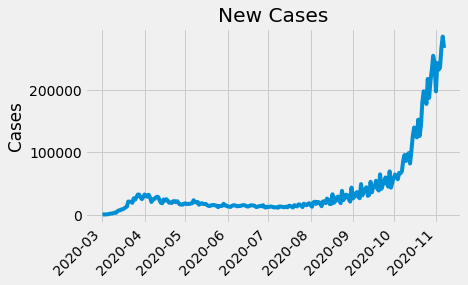

In [3]:
print('The number of (rows, columns):', df.shape)

dates = df['date']

# Set pyplot style
plt.style.use('fivethirtyeight')

# Set up the plotting layout
f1, ax = plt.subplots()
f1.autofmt_xdate(rotation = 45)

# Plot new cases
ax.plot(dates, df['new_cases'])
ax.set_xlabel(''); ax.set_ylabel('Cases'); ax.set_title('New Cases')

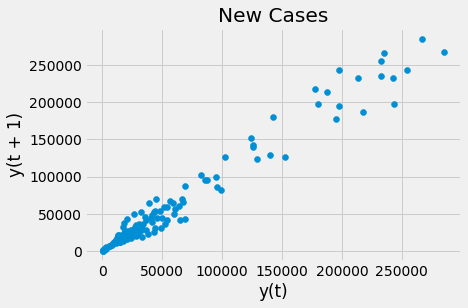

In [4]:
# Make lag plot
f2, ax = plt.subplots()
lag_plot(df['new_cases'], ax=ax)
ax.set_title('New Cases');

## Pre-processing: Detrend the Time Series

### Try Transforming the Data

Text(0.5, 1.0, 'Cbrt')

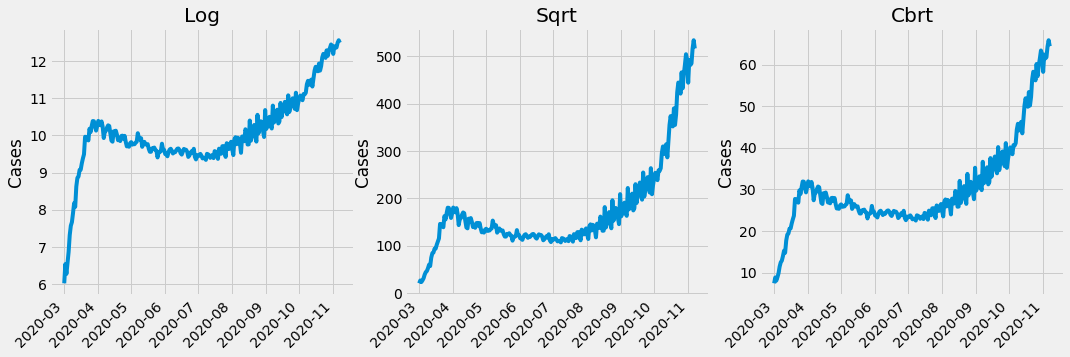

In [5]:
# Calculate the log
df['new_cases_log'] = np.log(df['new_cases'])

# Calculate the square root
df['new_cases_sqrt'] = np.sqrt(df['new_cases'])

# Calculate the cubed root
df['new_cases_cbrt'] = np.cbrt(df['new_cases'])

f3, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
f3.tight_layout()
f3.autofmt_xdate(rotation = 45)
ax1.plot(dates, df['new_cases_log'])
ax1.set_xlabel(''); ax1.set_ylabel('Cases'); ax1.set_title('Log')
ax2.plot(dates, df['new_cases_sqrt'])
ax2.set_xlabel(''); ax2.set_ylabel('Cases'); ax2.set_title('Sqrt')
ax3.plot(dates, df['new_cases_cbrt'])
ax3.set_xlabel(''); ax3.set_ylabel('Cases'); ax3.set_title('Cbrt')

### Try Rolling Means

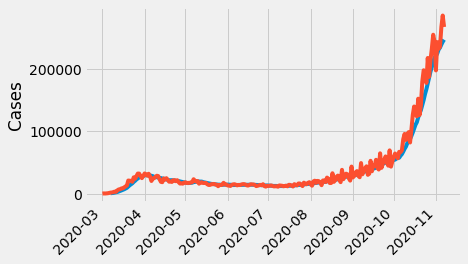

In [6]:
f4, ax = plt.subplots()
ax.plot(dates, df['new_cases'].rolling(window = 7).mean())
ax.plot(dates, df['new_cases'])
ax.set_xlabel(''); ax.set_ylabel('Cases'); ax1.set_title('Rolling Mean')
f4.autofmt_xdate(rotation = 45)

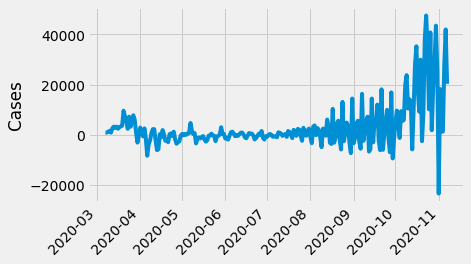

In [7]:
df['new_cases_rolling'] = df['new_cases'] - df['new_cases'].rolling(window = 7).mean()

f5, ax = plt.subplots()
ax.plot(dates, df['new_cases_rolling'])
ax.set_xlabel(''); ax.set_ylabel('Cases'); ax1.set_title('New Cases with the Rolling Mean Subtracted')
f5.autofmt_xdate(rotation = 45)

### Try Differencing

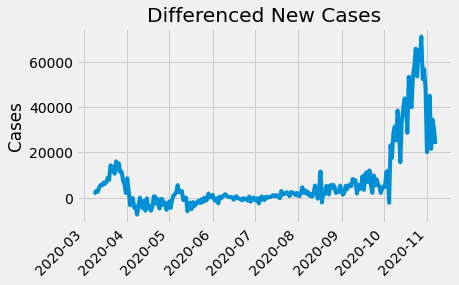

In [8]:
df['new_cases_diff'] = df['new_cases'].diff(periods=7)

f6, ax = plt.subplots()
ax.plot(dates, df['new_cases_diff'])
ax.set_xlabel(''); ax.set_ylabel('Cases'); ax.set_title('Differenced New Cases')
f6.autofmt_xdate(rotation = 45)

### Try Fitting Trend with a Polynomial Curve

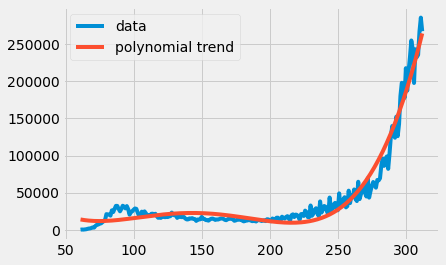

In [9]:
x = df.index
x = np.reshape(x, (len(x), 1))
y = df.new_cases

pf = PolynomialFeatures(degree=4)
xp = pf.fit_transform(x)
model = LinearRegression()
model.fit(xp, y)
trend = model.predict(xp)

plt.plot(x, y)
plt.plot(x, trend)
plt.legend(['data', 'polynomial trend'])

## Feature Engineering

In [10]:
# Remove detrending attempts that did not work
features = df.drop(['new_cases_log', 'new_cases_sqrt', 'new_cases_cbrt', 'new_cases_rolling'], axis = 1)

# Remove date column
features = features.drop('date', axis = 1)

# Create lags
lag = 3

def build_lagged_features(s,lag=3,dropna=True):
    if type(s) is pd.DataFrame:
        new_dict={}
        for col_name in s:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l*7)]=s[col_name].shift(l*7)
        res=pd.DataFrame(new_dict,index=s.index)
    if dropna:
        return res.dropna()
    else:
        return res 

lagged_features = build_lagged_features(features.drop(['day', 'month', 'year', 'weekday', 'new_cases'], axis = 1), lag=lag)
lagged_features['day'] = features['day'][lag:]
lagged_features['month'] = features['month'][lag:]
lagged_features['year'] = features['year'][lag:]
lagged_features['weekday'] = features['weekday'][lag:]
lagged_features['new_cases'] = features['new_cases'][lag:]

features = lagged_features
features = features.drop(['total_tests', 'new_tests'], axis = 1)

# One-hot encode weekdays
features = pd.get_dummies(features)

features.head(10)

,total_tests_lag7,total_tests_lag14,total_tests_lag21,new_tests_lag7,new_tests_lag14,new_tests_lag21,new_cases_diff,new_cases_diff_lag7,new_cases_diff_lag14,new_cases_diff_lag21,...,month,year,new_cases,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
89,1312444.0,558727.0,201581.0,45955.0,34410.0,13584.0,7520.0,12062.0,6578.0,1728.0,...,3,2020,28301.0,0,0,0,1,0,0,0
90,800807.0,408362.0,84028.0,68127.0,40732.0,9184.0,5826.0,10505.0,6048.0,2037.0,...,3,2020,25108.0,0,1,0,0,0,0,0
91,867941.0,434283.0,168718.0,63975.0,46241.0,13558.0,1971.0,15997.0,6825.0,3034.0,...,3,2020,28359.0,0,0,0,0,0,1,0
92,943649.0,499321.0,195766.0,72237.0,59038.0,27413.0,8475.0,12241.0,8636.0,2524.0,...,4,2020,32583.0,0,0,0,0,0,0,1
93,1033871.0,551681.0,163163.0,104188.0,59295.0,25413.0,3023.0,15127.0,7687.0,4624.0,...,4,2020,31423.0,0,0,0,0,1,0,0
94,1150083.0,645981.0,277814.0,97240.0,69392.0,29933.0,-3449.0,11165.0,14240.0,5543.0,...,4,2020,29007.0,1,0,0,0,0,0,0
95,1244492.0,686725.0,316596.0,94409.0,59744.0,39148.0,-222.0,11292.0,13766.0,5364.0,...,4,2020,32142.0,0,0,1,0,0,0,0
96,2342370.0,1312444.0,558727.0,133940.0,45955.0,34410.0,-320.0,7520.0,12062.0,6578.0,...,4,2020,27981.0,0,0,0,1,0,0,0
97,1133216.0,800807.0,408362.0,65181.0,68127.0,40732.0,-4533.0,5826.0,10505.0,6048.0,...,4,2020,20575.0,0,1,0,0,0,0,0
98,1608554.0,867941.0,434283.0,78729.0,63975.0,46241.0,-3873.0,1971.0,15997.0,6825.0,...,4,2020,24486.0,0,0,0,0,0,1,0


# Train random forest model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 49)
rf.fit(train_features, train_labels)

In [11]:
# Splitting into labels and features
labels = features['new_cases']
labels_diff = features['new_cases_diff']
features = features.drop(['new_cases', 'new_cases_diff'], axis = 1)
feature_list = list(features.columns)

In [12]:
# Splitting into training and testing sets
#train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 49)
# Using first 7 days of November as testing set
train_features = features[:-7]
test_features = features[-7:]
train_labels = labels_diff[:-7]
test_labels = labels[-7:]
test_features

,total_tests_lag7,total_tests_lag14,total_tests_lag21,new_tests_lag7,new_tests_lag14,new_tests_lag21,new_cases_diff_lag7,new_cases_diff_lag14,new_cases_diff_lag21,day,month,year,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
306,133342193.0,121399002.0,115704356.0,1024289.0,903180.0,769797.0,53570.0,28590.0,38471.0,1,11,2020,0,0,0,1,0,0,0
307,113402610.0,105472920.0,98435704.0,1386671.0,1166485.0,840606.0,65167.0,53409.0,31632.0,2,11,2020,0,1,0,0,0,0,0
308,114629519.0,108824003.0,99379884.0,1638326.0,1449093.0,1240491.0,61121.0,43934.0,15559.0,3,11,2020,0,0,0,0,0,1,0
309,118371429.0,107777589.0,102596302.0,1726914.0,1548739.0,1397131.0,71227.0,39942.0,33123.0,4,11,2020,0,0,0,0,0,0,1
310,131167039.0,121682171.0,110543217.0,1777173.0,1605420.0,1403101.0,52352.0,53658.0,38752.0,5,11,2020,0,0,0,0,1,0,0
311,132675629.0,110276967.0,102676628.0,1947139.0,1679128.0,1425738.0,56850.0,58033.0,43864.0,6,11,2020,1,0,0,0,0,0,0
312,132273986.0,107765384.0,105094452.0,1542039.0,1314468.0,1259852.0,48392.0,65889.0,42937.0,7,11,2020,0,0,1,0,0,0,0


In [13]:
# Convert to numpy array
train_features = np.array(train_features)
train_labels = np.array(train_labels)
test_features = np.array(test_features)
test_labels = np.array(test_labels)

In [14]:
# Train random forest model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 49)
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=49)

In [15]:
diff_predictions = rf.predict(test_features)

from pmdarima.utils import diff_inv
predictions = diff_inv(np.append(np.array(labels.iloc[-14:-7]), diff_predictions), lag=7, differences=1)
predictions = predictions[-7:]

## Evaluation

In [16]:
# Get Mean Absolute Error (MAE)
errors = abs(predictions - test_labels)
print('MAE:', round(np.mean(errors), 2), 'new cases')

MAE: 14398.65 new cases


In [17]:
# Get feature importances
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort feature importances descendingly by importance
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: new_cases_diff_lag7  Importance: 0.28
Variable: total_tests_lag7     Importance: 0.27
Variable: total_tests_lag14    Importance: 0.14
Variable: total_tests_lag21    Importance: 0.13
Variable: month                Importance: 0.06
Variable: new_tests_lag7       Importance: 0.05
Variable: day                  Importance: 0.03
Variable: new_cases_diff_lag14 Importance: 0.02
Variable: new_tests_lag14      Importance: 0.01
Variable: new_tests_lag21      Importance: 0.01
Variable: new_cases_diff_lag21 Importance: 0.01
Variable: year                 Importance: 0.0
Variable: weekday_Friday       Importance: 0.0
Variable: weekday_Monday       Importance: 0.0
Variable: weekday_Saturday     Importance: 0.0
Variable: weekday_Sunday       Importance: 0.0
Variable: weekday_Thursday     Importance: 0.0
Variable: weekday_Tuesday      Importance: 0.0
Variable: weekday_Wednesday    Importance: 0.0


## Export results

In [18]:
results = pd.DataFrame(predictions, index=dates.iloc[-7:], columns=['rf_europe'])
results

,rf_europe
date,
2020-11-01,217163.947
2020-11-02,260462.747
2020-11-03,229526.531
2020-11-04,257081.290
2020-11-05,274420.638
2020-11-06,297313.262
2020-11-07,286396.228


In [19]:
results.to_pickle('rf_predictions/rf_europe.pkl')